# Comparison of h-h and h-$\Lambda$ 2D Correlations
### using THnSparse methods
### Ravi Koka

Use `python-modules` kernel from the global AliPhysics installation. Additionally, ssh into `/broad/` so VSCode activates the .env file. 

In [1]:
import ROOT as rt
from ROOT import TCanvas, TMath, TGraph, TGraphErrors, TF1, gStyle

import numpy as np
import matplotlib.pyplot as plt


# magic for autoreloading modules, useful if import function from another Python file
%load_ext autoreload
%autoreload 2

# cool library, need perm to install
# import hist
# https://hist.readthedocs.io/en/latest/user-guide/notebooks/Plots.html

Welcome to JupyROOT 6.26/10


In [2]:
# magic for interactive ROOT plots
# %jsroot

In [3]:
# load the ROOT file
inFile = rt.TFile.Open("analysisMulti.root")

In [4]:
# load single particle histograms, TH3D
#   axes are: pT, phi, eta
allParticleDist = inFile.allParticleDist
chargedHadronDist = inFile.chargedHadronDist
lambdaDist = inFile.lambdaDist
triggeredLambdaDist = inFile.triggeredLambdaDist

# load correlation dists, 6D THnSparse 
#   axes are: trigger eta, associated eta, trigger pt, associated pt, delta phi, delta eta
hlDist = inFile.hLambdaDist
hhDist = inFile.hhDist

In [5]:
def format_hist(hist, color=1, size=1.4, style=20):
    '''
    Format histogram for readability. 
    
    Args
        hist (TH1, TH2): histogram
    '''

    #gPad.SetTickx();
    #gPad.SetTicky();
    hist.SetMarkerSize(size)
    hist.SetMarkerColor(color)
    hist.SetLineColor(color)
    hist.SetMarkerStyle(style)

    hist.GetXaxis().SetTitleFont(42)
    hist.GetXaxis().SetTitleOffset(1.0)
    hist.GetXaxis().SetTitleSize(0.045)
    hist.GetXaxis().SetLabelSize(0.045)

    hist.GetYaxis().SetTitleOffset(1.1)
    hist.GetYaxis().SetTitleSize(0.05)
    hist.GetYaxis().SetLabelSize(0.05)
    hist.GetYaxis().SetLabelFont(42)
    hist.GetXaxis().SetLabelFont(42)
    hist.GetYaxis().SetTitleFont(42)

# Correlation Distributions

Question: isn't cutting on THnSparse approximate?

In [6]:
# NOTES
# SetRangeUser is equivalent to SetRange(FindBin)
# SetRangeUser and FindBin will default to right if number is on bin edge, subtract off small amt to be careful
# hist = thn.Project(0).Clone('name') 
#   gives new string name that ROOT uses (you'll see it in top right corner)
#   need to be careful abt string name, if it gets copied to another object, can go wrong (ex. if set SetRangeUser to original bounds)
# can also use: hist.SetName()
# to reset range use SetRangeUser(0, 0)


# look at how delta eta changes given a pT cut
# check how eta ranges match bin edges
# ADD ASSERT STATEMENTS !!

# dist.GetAxis(axis['trigger eta']).SetRangeUser(-0.8, 0.8)

# if increase pT range, expect 2D corr to get sharper
# can also get more triangular del eta if mess with pT or eta i forgor
#   corr two finite random variables = triangle

# stack vs heap
# https://courses.engr.illinois.edu/cs225/fa2022/resources/stack-heap/#:~:text=stack%20%3A%20stores%20local%20variables,stores%20the%20code%20being%20executed

In [7]:
# define to make projections of THnSparse more readable
#   the ints correspond to a particular axis of the correlation THnSparse
axis = {'trigger eta': 0, 'associate eta': 1, 'trigger pT': 2, 'associate pT': 3, 'delta phi': 4, 'delta eta': 5}

In [8]:
# HYPERPARAM
eps = 0.0001
etaMin, etaMax = -0.8, 0.8 - eps

eta = [
    [-2, 2-eps], 
    [-1.2, 1.2-eps], 
    [-0.8, 0.8-eps]]

ptTrig = [4, 8]
ptAssoc = [2, 4]

# change. 

## Plots with No Cuts

In [9]:
def make_projection_plots(sparse, ptTrig, ptAssoc):
    '''
    Makes 1D histograms of quantities from THnSparse, and 2D delta phi delta eta correlation. 
    No single particle cuts applied in this function. 

    Args
        sparse (THnSparse):
    
    Returns
        canvas (TCanvas): 
    '''
    ptTrigMin, ptTrigMax = ptTrig
    ptAssocMin, ptAssocMax = ptAssoc

    # select pT cuts for trigger and associate
    sparse.GetAxis(axis['trigger pT']).SetRangeUser(ptTrigMin, ptTrigMax)
    sparse.GetAxis(axis['associate pT']).SetRangeUser(ptAssocMin, ptAssocMax)

    # project to make 1D hists
    trigEta = sparse.Projection(axis['trigger eta'])
    assocEta = sparse.Projection(axis['associate eta'])
    trigPt = sparse.Projection(axis['trigger pT'])
    assocPt = sparse.Projection(axis['associate pT'])
    #dEta = sparse.Projection(axis['delta eta']) 

    # project into 2D correlations and delta eta dist
    dPhiDEta = sparse.Projection(axis['delta eta'], axis['delta phi'])
    dEta = dPhiDEta.ProjectionY()

    # reset sparse pT axes
    sparse.GetAxis(axis['trigger pT']).SetRangeUser(0, 0)
    sparse.GetAxis(axis['associate pT']).SetRangeUser(0, 0)

    # make canvas
    gStyle.SetOptStat(11)
    canvas = TCanvas('canvas', 'title')
    canvas.SetCanvasSize(1800, 800)
    canvas.Divide(3, 2)

    canvas.cd(1)
    format_hist(trigEta)
    trigEta.SetTitle('Trigger #eta')
    trigEta.SetXTitle('#eta')
    trigEta.SetYTitle('counts')
    trigEta.Draw('COLZ')


    canvas.cd(2)
    format_hist(assocEta)
    assocEta.SetTitle('Associate #eta')
    assocEta.SetXTitle('#eta')
    assocEta.SetYTitle('counts')
    assocEta.Draw('COLZ')


    canvas.cd(3)
    format_hist(trigPt)
    trigPt.SetTitle('Trigger p_{T}')
    trigPt.SetXTitle('p_{T}')
    trigPt.SetYTitle('counts')
    trigPt.Draw('COLZ')


    canvas.cd(4)
    format_hist(assocPt)
    assocPt.SetTitle('Associate p_{T}')
    assocPt.SetXTitle('p_{T}')
    assocPt.SetYTitle('counts')
    assocPt.Draw('COLZ')


    canvas.cd(5)
    format_hist(dPhiDEta)
    dPhiDEta.SetTitle('Correlation')
    dPhiDEta.SetXTitle('#Delta#varphi')
    dPhiDEta.SetYTitle('#Delta#eta')
    dPhiDEta.GetYaxis().SetRangeUser(-1.2, 1.199)
    dPhiDEta.Draw('SURF1')


    canvas.cd(6)
    format_hist(dEta)
    dEta.SetTitle('#Delta#eta')
    dEta.SetXTitle('#Delta#eta')
    dEta.SetYTitle('counts')
    dEta.Draw()    

    return canvas

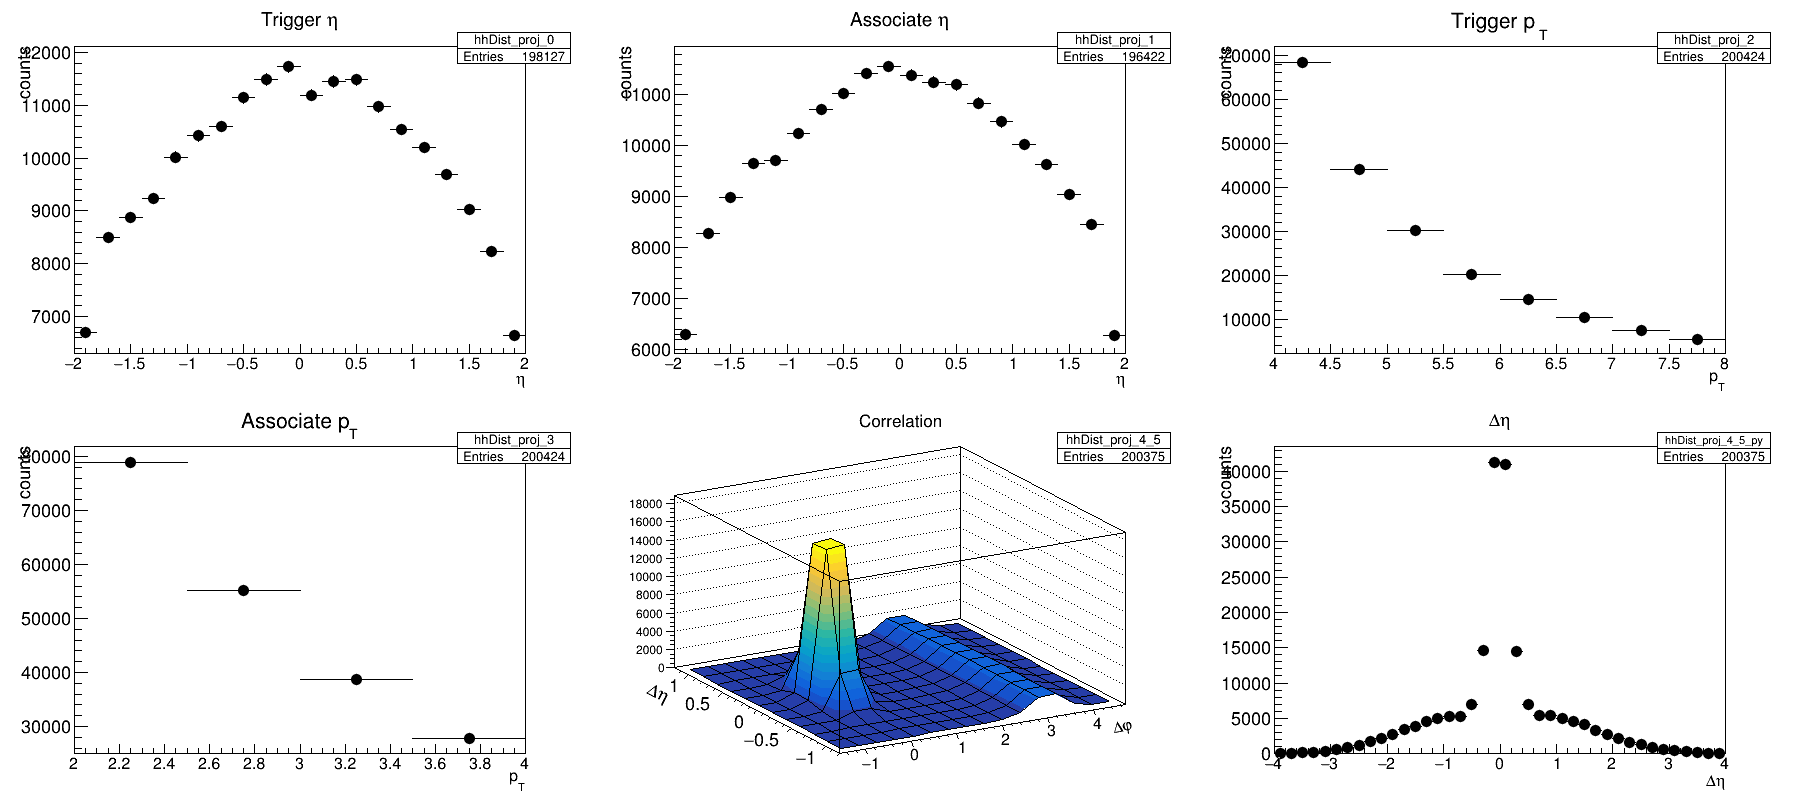

In [10]:
c1 = make_projection_plots(hhDist, ptTrig, ptAssoc)
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


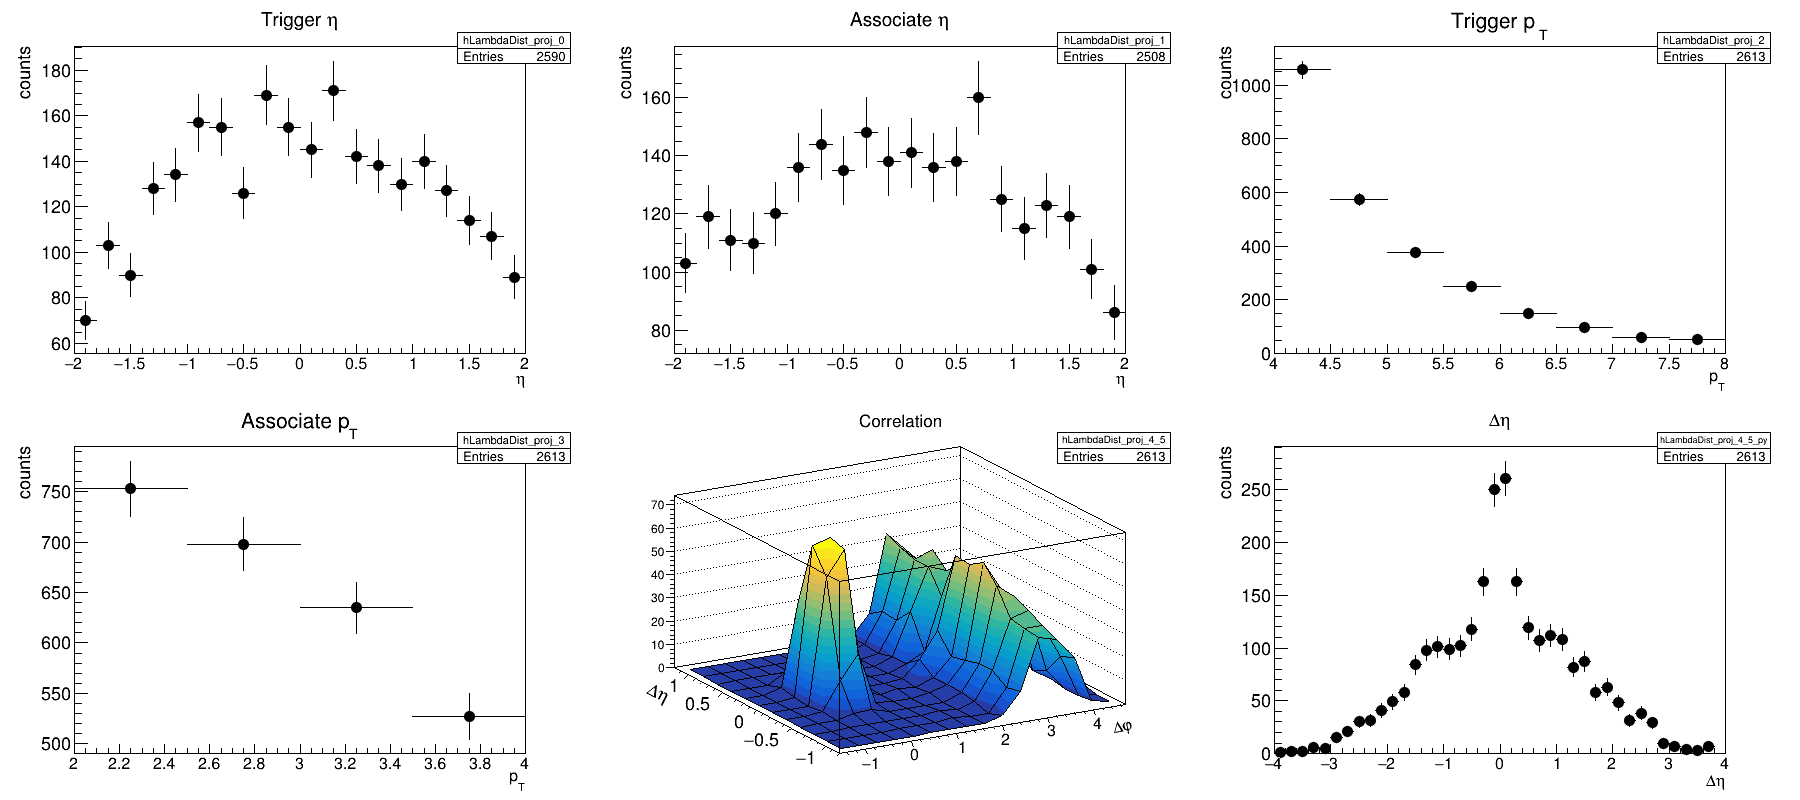

In [11]:
c2 = make_projection_plots(hlDist, ptTrig, ptAssoc)
c2.Draw()

## Away Side Ratios

In [12]:
# Skeleton of the following analysis: 
# for both hh and hL
# select pT range for trigger and associate
# for each eta cut
#   plot delta phi delta eta
#   integrate away side peak counts
#   reset eta cut

In [13]:
def integrate_away_side(correlation):
    '''
    Helper function for get_away_side_ratios(). Calculates the counts in the away side peak of a 2D delta phi delta eta correlation.

    Args
        correlation (TH2):

    Returns
        away_yield (float): 
    '''

    # bounds of integral
    pi = TMath.Pi()
    eps = 0.0001 # in case upper bound lands on right bin edge
    dPhi_lower = pi / 2
    dPhi_upper = 3 * pi / 2 - eps
    dEta_lower = -50
    dEta_upper = 50 - eps

    dPhiLowerBin = correlation.GetXaxis().FindBin(dPhi_lower)
    dPhiUpperBin = correlation.GetXaxis().FindBin(dPhi_upper)

    dEtaLowerBin = correlation.GetYaxis().FindBin(dEta_lower)
    dEtaUpperBin = correlation.GetYaxis().FindBin(dEta_upper)

    away_yield = correlation.Integral(dPhiLowerBin, dPhiUpperBin, dEtaLowerBin, dEtaUpperBin)

    return away_yield

In [14]:
def get_away_side_ratios(sparse1, sparse2, ptTrig, ptAssoc, etaRanges):
    '''
    Given a particular single particle pT and eta cut, 
    returns the ratio of counts in the away side peak for a del phi del eta distribution. 

    Args
        sparse1 (THnSparse): numerator
        sparse2 (THnSparse): denomen
        ptTrig (array-like):
        ptAssoc (array-like):
        etaRanges (array-like):

    Returns
        ratios (tuple): h-Lambda / h-h for given single particle and eta cut
    '''

    # apply pT cut
    ptTrigMin, ptTrigMax = ptTrig
    ptAssocMin, ptAssocMax = ptAssoc

    sparse1.GetAxis(axis['trigger pT']).SetRangeUser(ptTrigMin, ptTrigMax)
    sparse2.GetAxis(axis['trigger pT']).SetRangeUser(ptTrigMin, ptTrigMax)

    sparse1.GetAxis(axis['associate pT']).SetRangeUser(ptAssocMin, ptAssocMax)
    sparse2.GetAxis(axis['associate pT']).SetRangeUser(ptAssocMin, ptAssocMax)
    
    yieldRatios = []
    yieldRatiosUncerts = []
    # iterate over eta cuts
    for etaRange in etaRanges:
        etaMin, etaMax = etaRange

        # apply eta cuts
        sparse1.GetAxis(axis['trigger eta']).SetRangeUser(etaMin, etaMax)
        sparse2.GetAxis(axis['trigger eta']).SetRangeUser(etaMin, etaMax)

        sparse1.GetAxis(axis['associate eta']).SetRangeUser(etaMin, etaMax)
        sparse2.GetAxis(axis['associate eta']).SetRangeUser(etaMin, etaMax)

        # project into 2D correlations
        dPhiDEta1 = sparse1.Projection(axis['delta eta'], axis['delta phi'])
        dPhiDEta2 = sparse2.Projection(axis['delta eta'], axis['delta phi']) 

        # integrate the counts in the away side peak
        awayCts1 = integrate_away_side(dPhiDEta1)
        awayCts2 = integrate_away_side(dPhiDEta2)

        awayYieldRatio = awayCts1 / awayCts2
        yieldRatios.append(awayYieldRatio)

        # naive calc: standard formula for uncertainty w/ division, assuming we treat the away side as one large bin
        # is this valid??
        assert awayYieldRatio > 0, 'ratio should be positive'
        sigma = awayYieldRatio * np.sqrt( 1 / awayCts1 + 1 / awayCts2)
        yieldRatiosUncerts.append(sigma)


    # reset dist axes
    sparse1.GetAxis(axis['trigger pT']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['trigger pT']).SetRangeUser(0, 0)

    sparse1.GetAxis(axis['associate pT']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['associate pT']).SetRangeUser(0, 0)

    sparse1.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)

    sparse1.GetAxis(axis['associate eta']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['associate eta']).SetRangeUser(0, 0)

    return yieldRatios, yieldRatiosUncerts

In [15]:
hlOverhh, hlOverhhSigma = get_away_side_ratios(hlDist, hhDist, ptTrig=[4, 8], ptAssoc=[2, 4], etaRanges=eta)

Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).


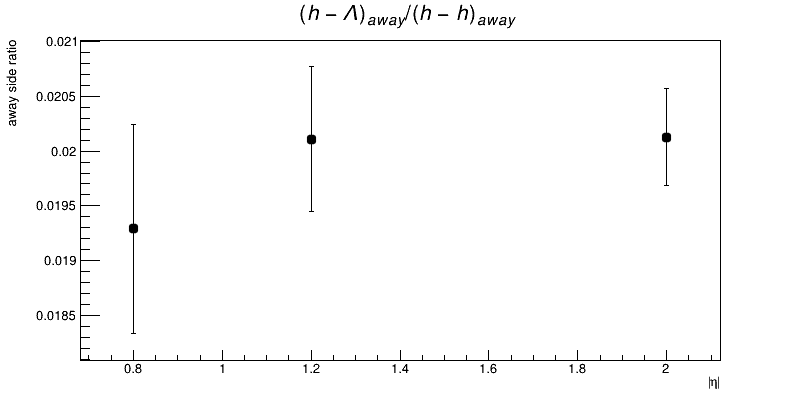

In [16]:
x = []
for etaRange in eta:
    x.append(np.abs(etaRange[0]))

# flatten data for TGraph
x = np.array(x, dtype='d').ravel()#.flatten('C')
y = np.array(hlOverhh, dtype='d').ravel()#.flatten('C')
sigmax = np.zeros(len(x))
sigmay = np.array(hlOverhhSigma, dtype='d').ravel()

#g = TGraph(len(x), x, y)
assert (len(x) == len(y)) and (len(x) == len(sigmay))
g = TGraphErrors(len(x), x, y, ex=sigmax, ey=sigmay)
g.SetMarkerStyle(107)
g.SetTitle('#(h - \Lambda)_{away} / (h - h)_{away}; |#eta|; away side ratio')


gCanvas = TCanvas()
gCanvas.SetCanvasSize(800, 400)
g.Draw("ap") # draw as scatter points and the axis
gCanvas.Draw()

 FCN=0.327644 FROM MIGRAD    STATUS=CONVERGED      42 CALLS          43 TOTAL
                     EDM=4.95163e-22    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.91692e-02   9.54360e-04   1.37730e-07   8.06089e-08
   2  p1           4.40385e-04   5.92463e-04   1.37730e-07   1.71294e-07


Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existin

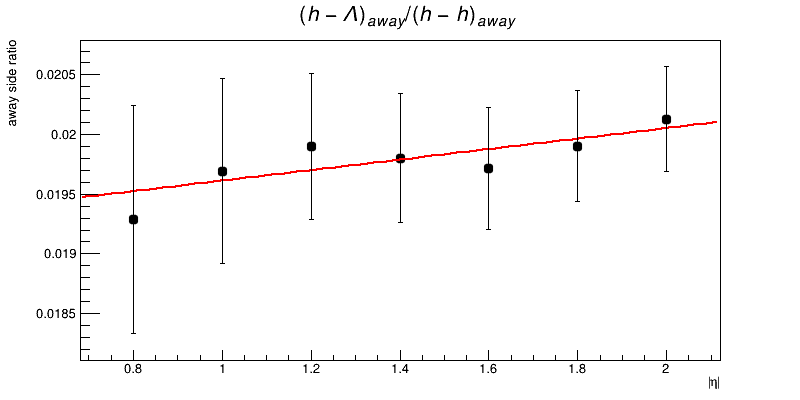

In [17]:
dense_eta = [[-i*10**-1 , i*10**-1 - eps] for i in range(8, 22, 2)]

x = []
for etaRange in dense_eta:
    x.append(np.abs(etaRange[0]))

y, sigmay = get_away_side_ratios(hlDist, hhDist, ptTrig=[4, 8], ptAssoc=[2, 4], etaRanges=dense_eta)

x = np.array(x, dtype='d').ravel()
y = np.array(y, dtype='d').ravel()
sigmax = np.zeros(len(x)).ravel()
sigmay = np.array(sigmay, dtype='d')

dg = TGraphErrors(len(x), x, y, ex=sigmax, ey=sigmay)
f = TF1('f', '[0] + [1]*x')
dg.Fit(f)

dg.SetMarkerStyle(107)
dg.SetTitle('#(h - \Lambda)_{away} / (h - h)_{away}; |#eta|; away side ratio')


dgCanvas = TCanvas()
dgCanvas.SetCanvasSize(800, 400)
dg.Draw("ap") # draw as scatter points and the axis
dgCanvas.Draw()

## Plots w/ Cuts

In [18]:
def gen_plots_w_eta_cuts(sparse, name, ptTrig, ptAssoc, etaRanges):
    '''
    Args
        sparse (THnSparse):
        ptTrig (array-like):
        ptAssoc (array-like):
        etaRanges (array-like):
    '''

    canvases = []
    # iterate over eta cuts
    for i, etaRange in enumerate(etaRanges):
        etaMin, etaMax = etaRange

        # apply eta cuts
        sparse.GetAxis(axis['trigger eta']).SetRangeUser(etaMin, etaMax)
        sparse.GetAxis(axis['associate eta']).SetRangeUser(etaMin, etaMax)

        # produce canvas w/ plots
        canvas = make_projection_plots(sparse, ptTrig, ptAssoc)
        canvas.SetName(f'{name}Canvas{np.abs(etaMin)}')
        canvases.append(canvas)

        # reset dist axes    
        sparse.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)
        sparse.GetAxis(axis['associate eta']).SetRangeUser(0, 0)
    
    return canvases

In [19]:
hhCanvas2, hhCanvas12, hhCanvas08 = gen_plots_w_eta_cuts(hhDist, 'hh', ptTrig, ptAssoc, eta)

Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <

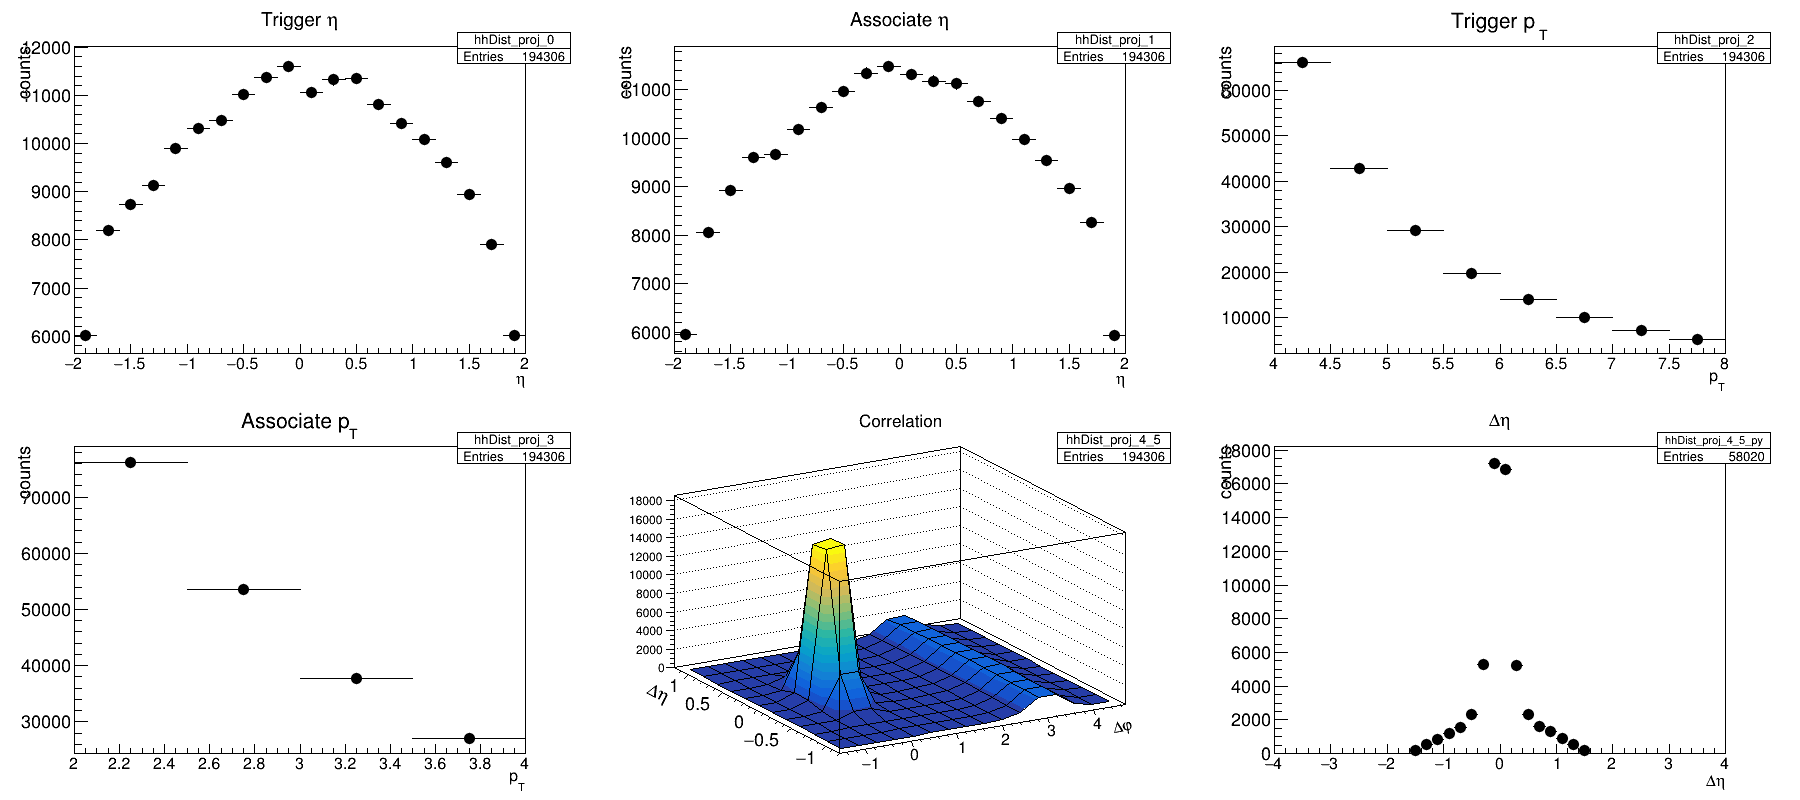

In [20]:
hhCanvas2.Draw()

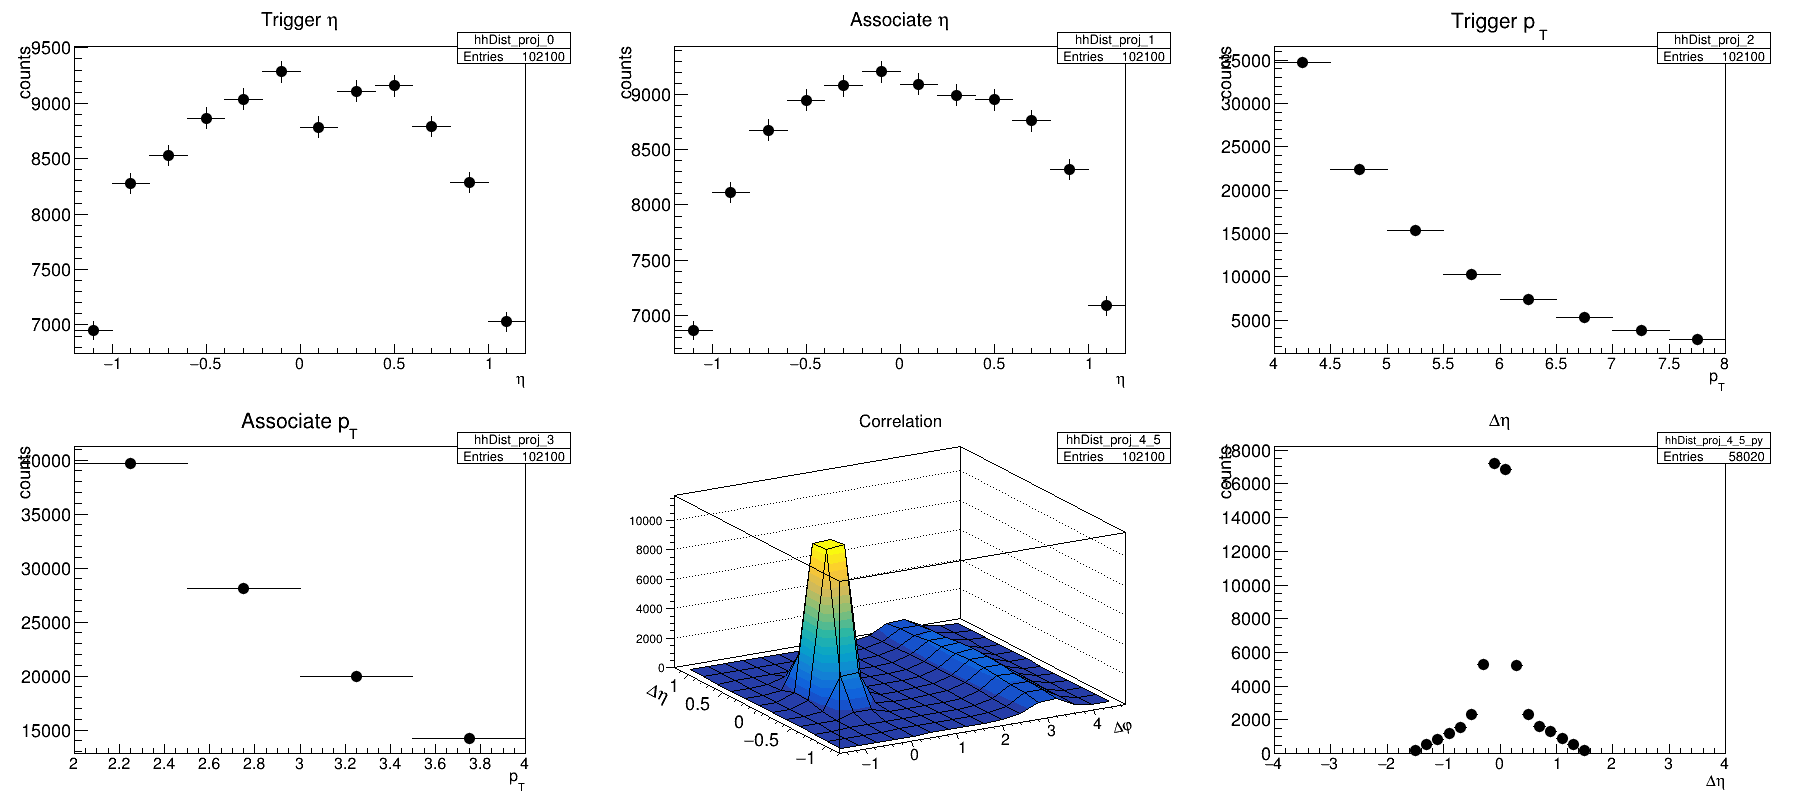

In [21]:
hhCanvas12.Draw()

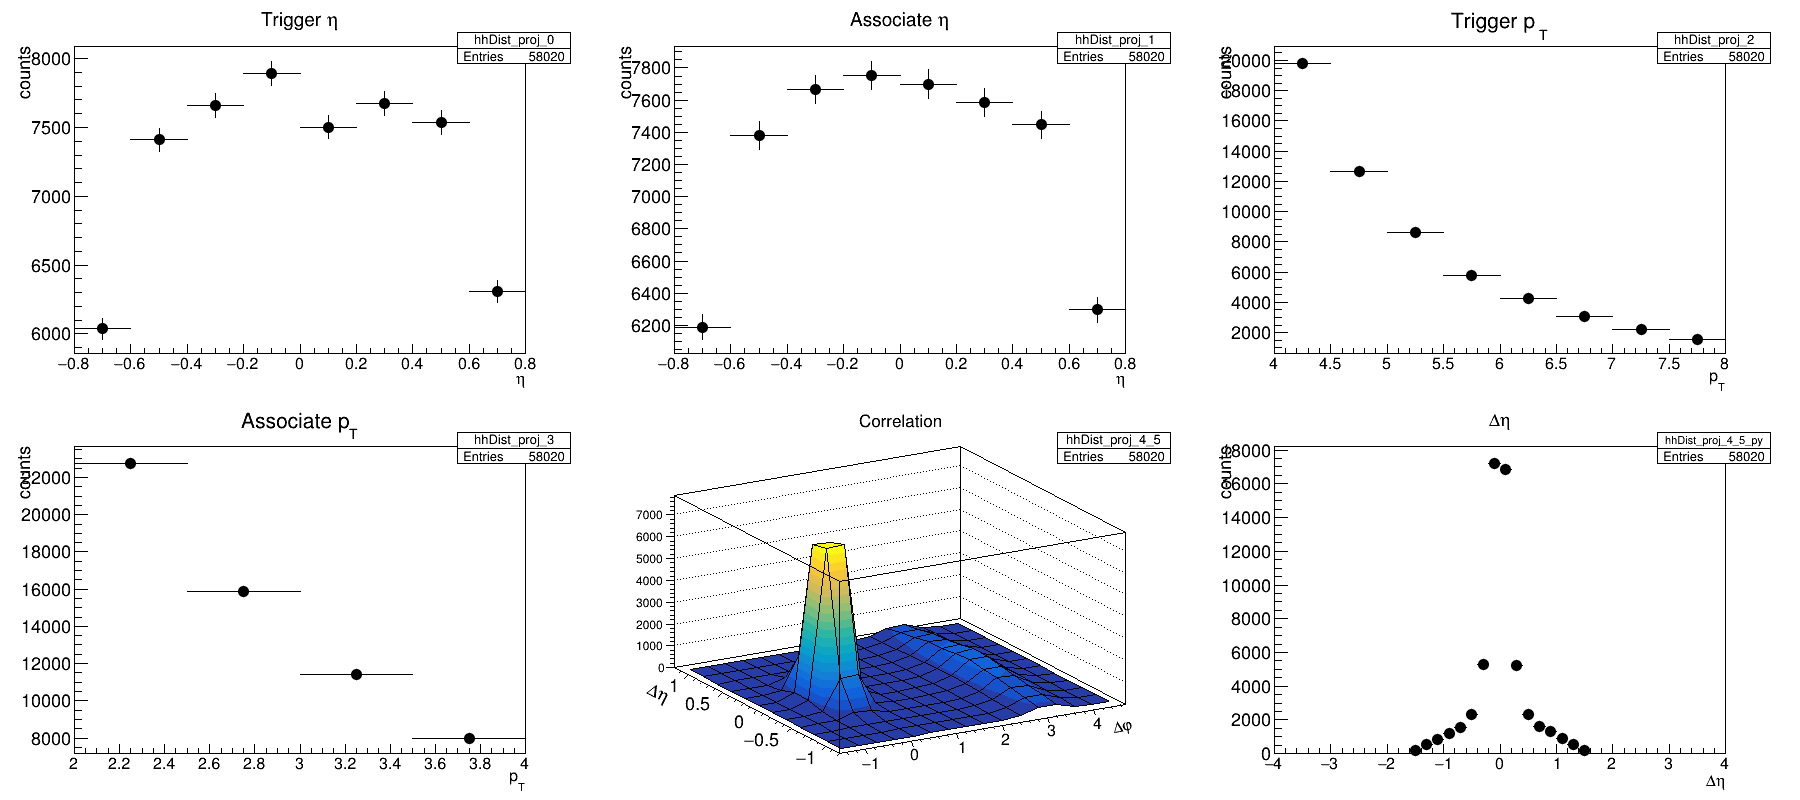

In [22]:
hhCanvas08.Draw()

In [23]:
hlCanvas2, hlCanvas12, hlCanvas08 = gen_plots_w_eta_cuts(hlDist, 'hl', ptTrig, ptAssoc, eta)

Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacin

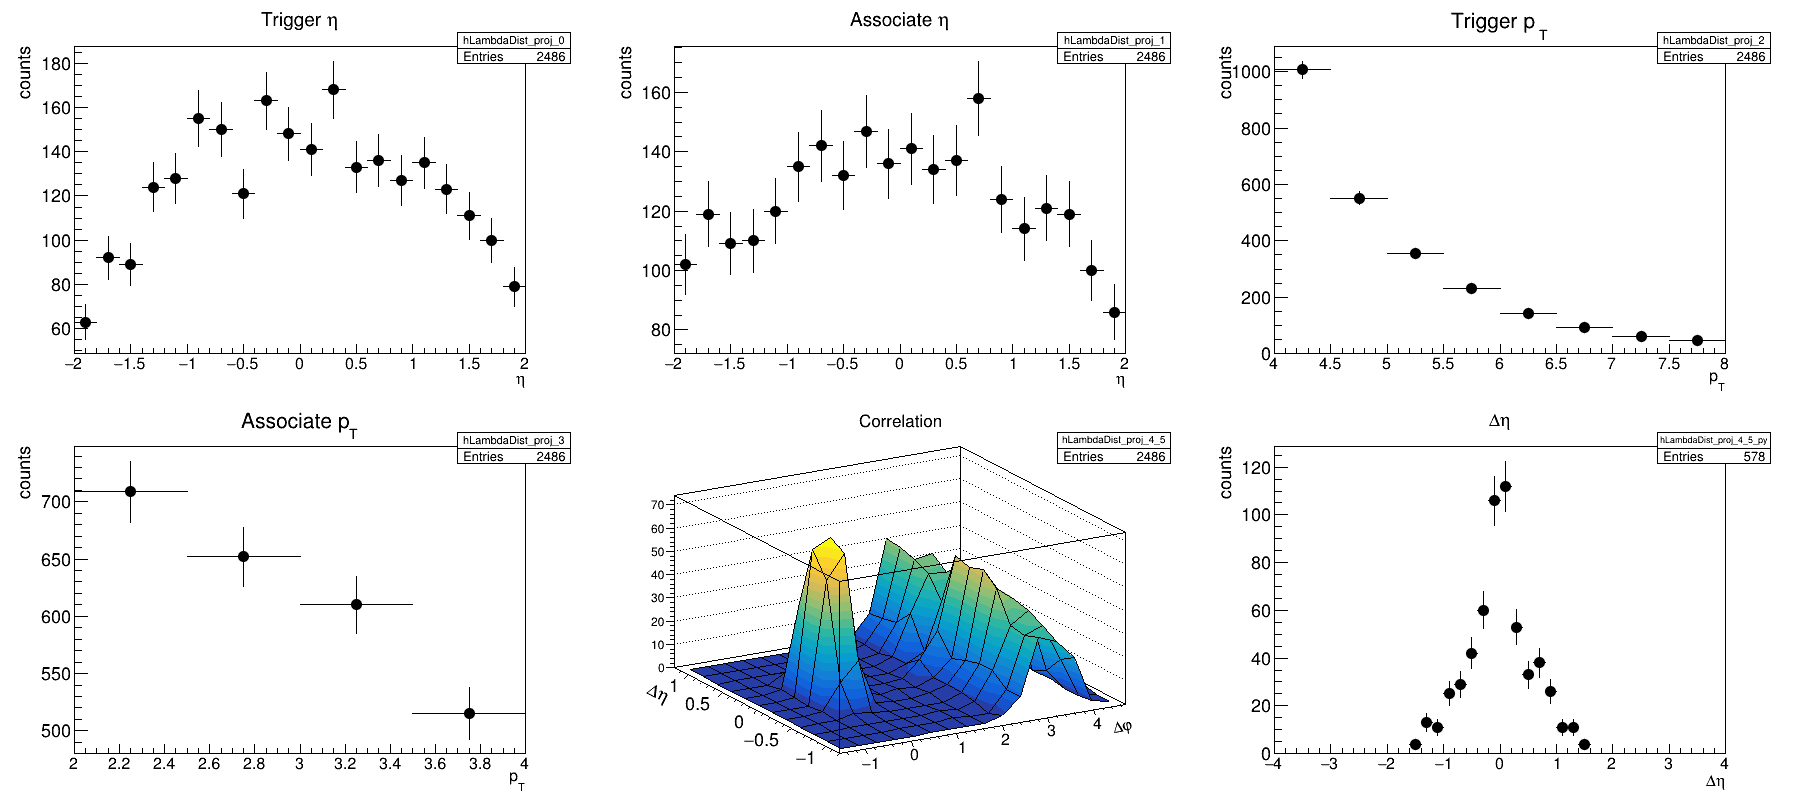

In [24]:
hlCanvas2.Draw()

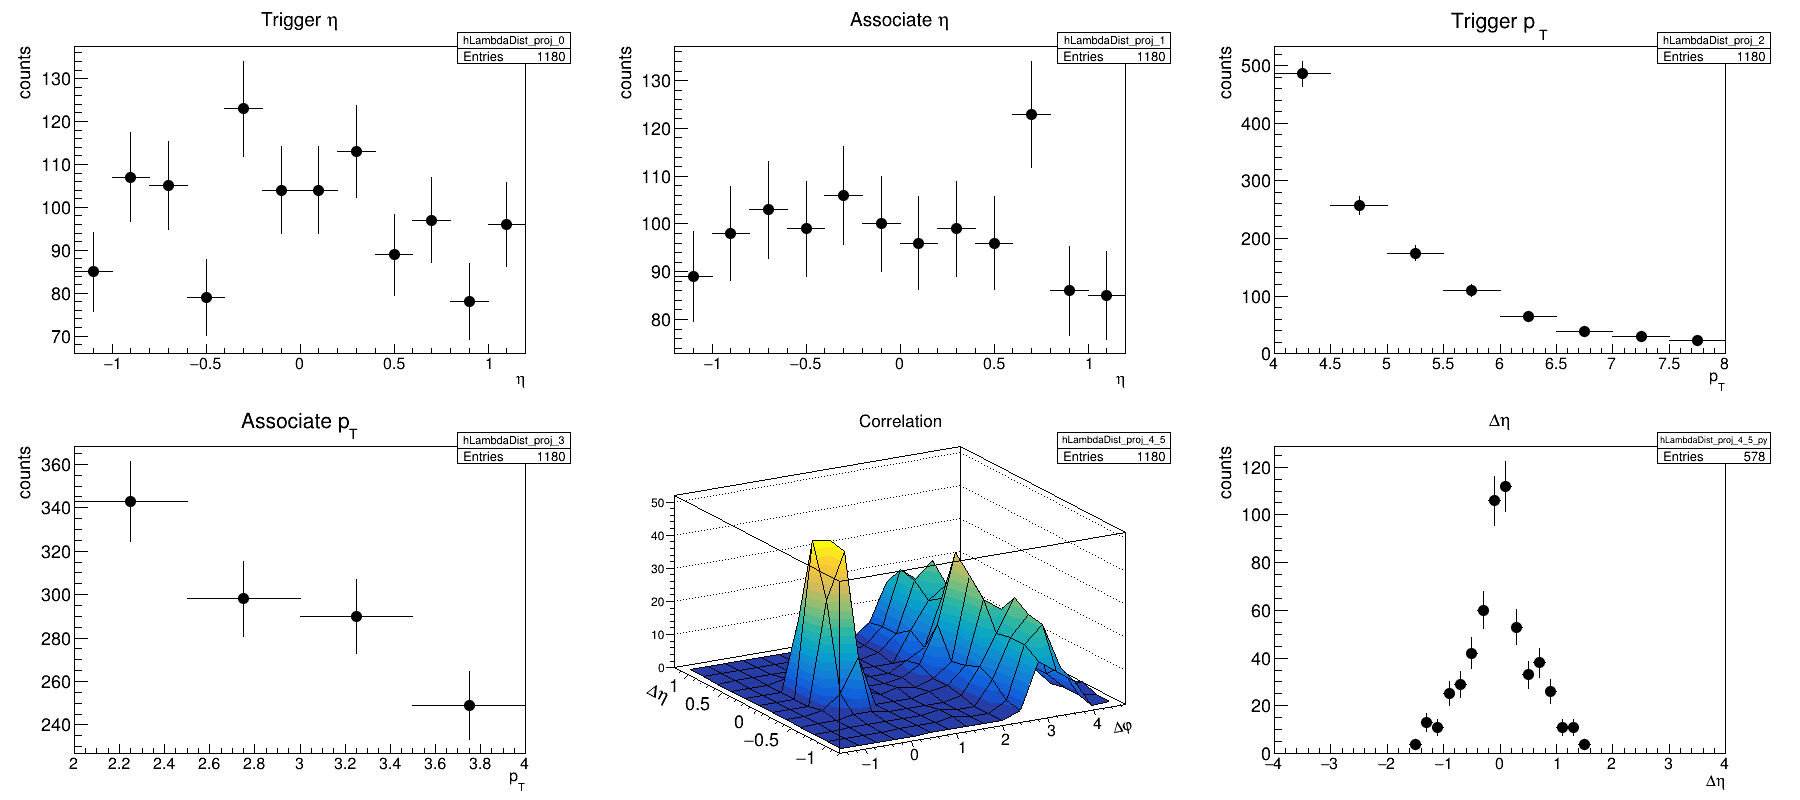

In [25]:
hlCanvas12.Draw()

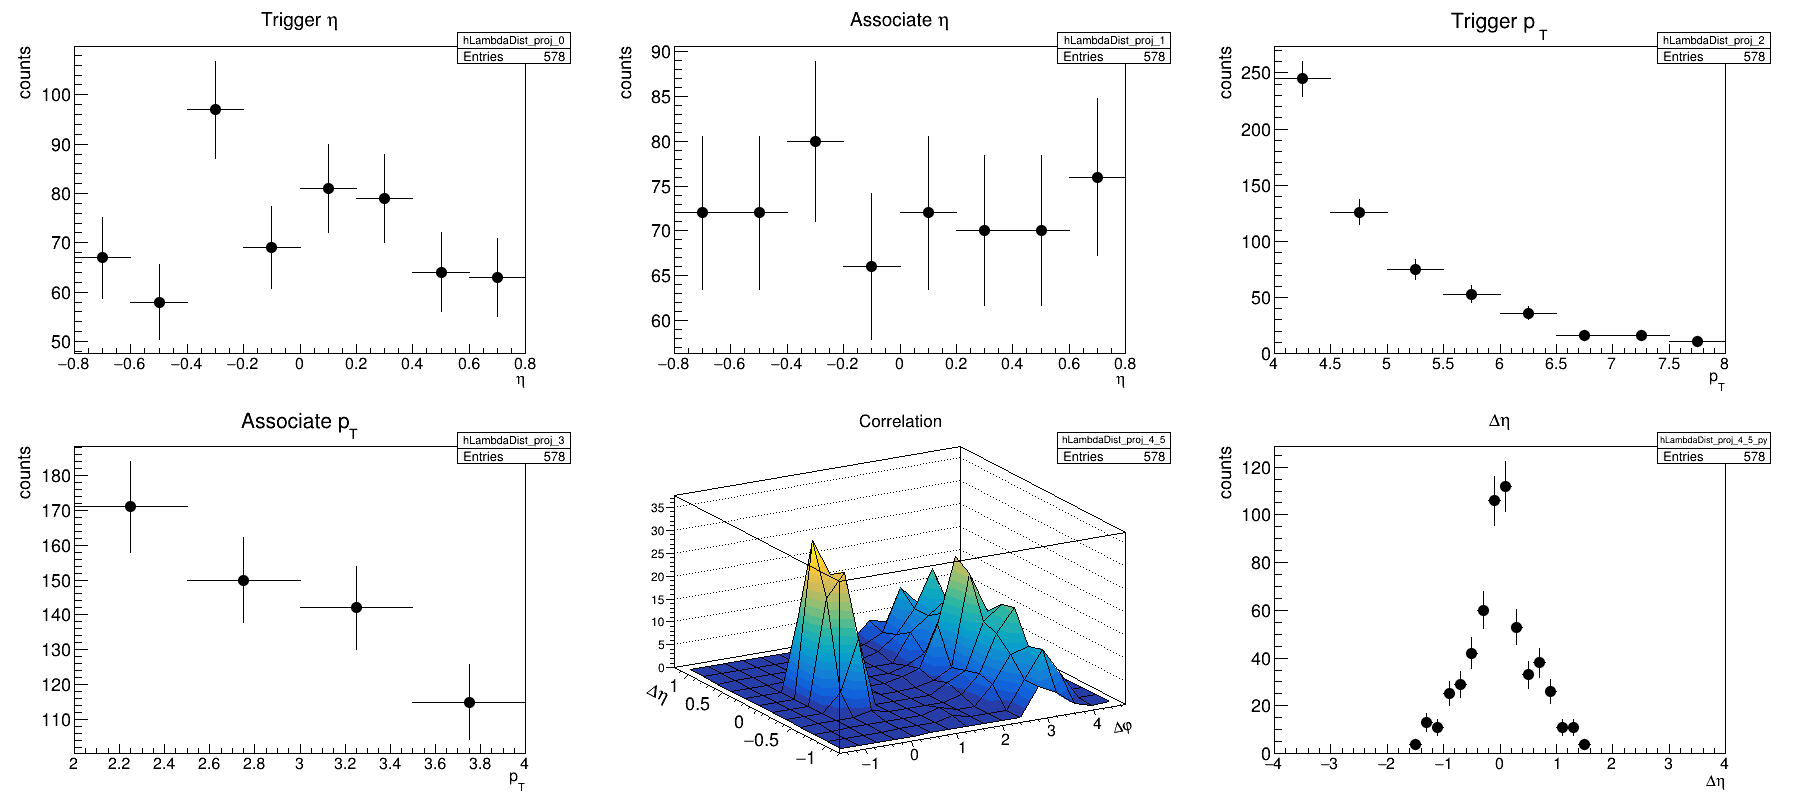

In [26]:
hlCanvas08.Draw()

## $\Delta \eta$ Distributions for Each Cut

In [27]:
def make_delta_eta_plots(sparse1, sparse2, ptTrig, ptAssoc, etaRanges):

    canvases = []
    # iterate over eta cuts
    for i, etaRange in enumerate(etaRanges):
        etaMin, etaMax = etaRange

        canvas = TCanvas()

        # apply eta cuts
        sparse1.GetAxis(axis['trigger eta']).SetRangeUser(etaMin, etaMax)
        sparse1.GetAxis(axis['associate eta']).SetRangeUser(etaMin, etaMax)

        sparse2.GetAxis(axis['trigger eta']).SetRangeUser(etaMin, etaMax)
        sparse2.GetAxis(axis['associate eta']).SetRangeUser(etaMin, etaMax)  

        dEta1 = sparse1.Projection(axis['delta eta'])
        dEta1.Scale(1. / dEta1.Integral())#, "WIDTH")      scale to describe PDF or normalize to a prob distribution 

        dEta2 = sparse2.Projection(axis['delta eta'])
        dEta2.Scale(1. / dEta2.Integral())#, "WIDTH")
        dEta2.SetMarkerColor(2)      

        dEta1.Draw()
        dEta2.Draw('SAME')

        # produce canvas w/ plots
        canvas.SetName(f'delEatCanvas{np.abs(etaMin)}')
        canvases.append(canvas)

        # reset dist axes    
        sparse1.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)
        sparse1.GetAxis(axis['associate eta']).SetRangeUser(0, 0)
        sparse2.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)
        sparse2.GetAxis(axis['associate eta']).SetRangeUser(0, 0)
    
    return canvases

In [28]:
dEta2, dEta12, dEta08 = make_delta_eta_plots(hhDist, hlDist, ptTrig, ptAssoc, eta)

Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_5 (Potential memory leak).


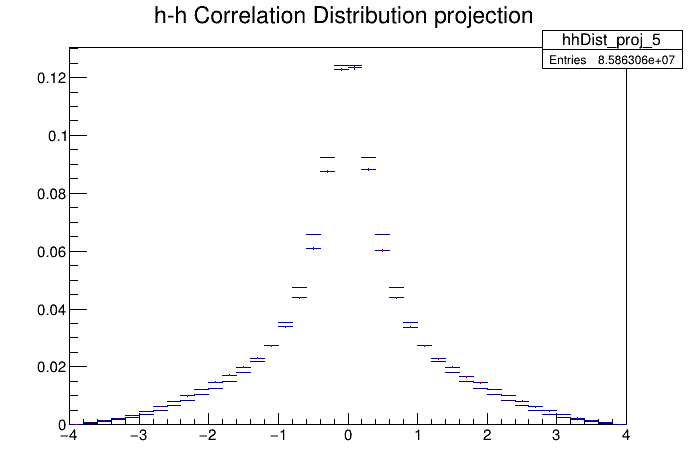

In [29]:
dEta2.Draw()

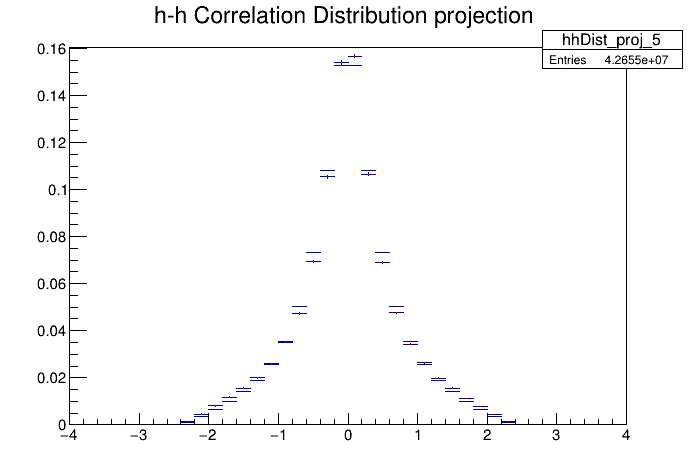

In [30]:
dEta12.Draw()

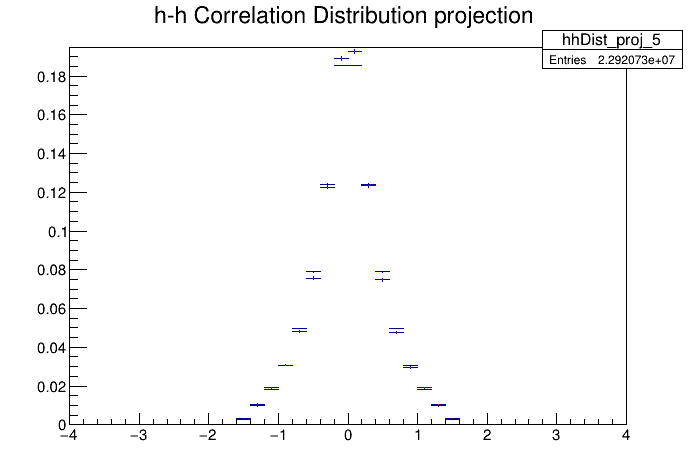

In [31]:
dEta08.Draw()

## $\Delta \varphi$ Distributions

# Single Particle Distributions

# Code Snippets

In [32]:
""" 
# get projections
# write projections
# close written file
# reaccess 

def sparse_to_temp_file(sparse):
    '''
    Writes 2D correlations and 1D correlations to a temp file. Keeps the file w/in local scope, so we can safely open it later.

    Args:
        sparse: THnSparse object
    '''
    dPhiDEta = sparse.Projection(5, 4)
    dPhi = sparse.Projection(5)
    dEta = sparse.Projection(4)

    tempFile = rt.TFile.Open('tempFile.root', 'RECREATE')
    tempFile.WriteObject(dPhiDEta, 'dPhiDEta')
    tempFile.WriteObject(dPhi, 'dPhi')
    tempFile.WriteObject(dEta, 'dEta') """

" \n# get projections\n# write projections\n# close written file\n# reaccess \n\ndef sparse_to_temp_file(sparse):\n    '''\n    Writes 2D correlations and 1D correlations to a temp file. Keeps the file w/in local scope, so we can safely open it later.\n\n    Args:\n        sparse: THnSparse object\n    '''\n    dPhiDEta = sparse.Projection(5, 4)\n    dPhi = sparse.Projection(5)\n    dEta = sparse.Projection(4)\n\n    tempFile = rt.TFile.Open('tempFile.root', 'RECREATE')\n    tempFile.WriteObject(dPhiDEta, 'dPhiDEta')\n    tempFile.WriteObject(dPhi, 'dPhi')\n    tempFile.WriteObject(dEta, 'dEta') "

In [33]:
""" sparse_to_temp_file(hhDist)

file = uproot.open('tempFile.root')

dPhiDEta, x_edges, y_edges = file['dPhiDEta'].to_numpy()
dPhi, dPhi_edges = file['dPhi'].to_numpy()
dEta, dEta_edges = file['dEta'].to_numpy() """

" sparse_to_temp_file(hhDist)\n\nfile = uproot.open('tempFile.root')\n\ndPhiDEta, x_edges, y_edges = file['dPhiDEta'].to_numpy()\ndPhi, dPhi_edges = file['dPhi'].to_numpy()\ndEta, dEta_edges = file['dEta'].to_numpy() "

In [34]:
""" # https://stackoverflow.com/questions/40200070/what-does-axis-0-do-in-numpys-sum-function
testPhi = np.sum(dPhiDEta, axis=0)
testEta = np.sum(dPhiDEta, axis=1) """

' # https://stackoverflow.com/questions/40200070/what-does-axis-0-do-in-numpys-sum-function\ntestPhi = np.sum(dPhiDEta, axis=0)\ntestEta = np.sum(dPhiDEta, axis=1) '

In [35]:
""" fig, axs = plt.subplots(1, 3)

axs[0].stairs(testPhi, y_edges)
axs[1].stairs(testEta, x_edges)
axs[2].imshow(dPhiDEta.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]) """

" fig, axs = plt.subplots(1, 3)\n\naxs[0].stairs(testPhi, y_edges)\naxs[1].stairs(testEta, x_edges)\naxs[2].imshow(dPhiDEta.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]) "

In [36]:
""" # Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax.imshow(dPhiDEta.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
ax_histx.hist(testPhi, bins=y_edges)
ax_histy.hist(testEta, bins=x_edges, orientation='horizontal') """

" # Start with a square Figure.\nfig = plt.figure(figsize=(6, 6))\n# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between\n# the size of the marginal axes and the main axes in both directions.\n# Also adjust the subplot parameters for a square plot.\ngs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),\n                      left=0.1, right=0.9, bottom=0.1, top=0.9,\n                      wspace=0.05, hspace=0.05)\n# Create the Axes.\nax = fig.add_subplot(gs[1, 0])\nax_histx = fig.add_subplot(gs[0, 0], sharex=ax)\nax_histy = fig.add_subplot(gs[1, 1], sharey=ax)\n\nax.imshow(dPhiDEta.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])\nax_histx.hist(testPhi, bins=y_edges)\nax_histy.hist(testEta, bins=x_edges, orientation='horizontal') "

In [37]:
""" def sparse_to_uproot(sparse):
    '''
    Takes THnSparse and returns a 2D correlation with projections into eta and phi.
    '''




    
     

 """

" def sparse_to_uproot(sparse):\n    '''\n    Takes THnSparse and returns a 2D correlation with projections into eta and phi.\n    '''\n\n\n\n\n    \n     \n\n "

In [38]:
""" file = uproot.open('testFile.root') """

" file = uproot.open('testFile.root') "

In [39]:
""" file.keys() """

' file.keys() '

In [40]:
""" # https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html
myhist, xedges, yedges= file['myhist'].to_numpy()

fig, ax = plt.subplots()
plt.imshow(myhist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]) """

" # https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html\nmyhist, xedges, yedges= file['myhist'].to_numpy()\n\nfig, ax = plt.subplots()\nplt.imshow(myhist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]) "

In [41]:
""" # https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html



fig = plt.figure()
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax.set(aspect=1)

ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)


 """

' # https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html\n\n\n\nfig = plt.figure()\nax = fig.add_gridspec(top=0.75, right=0.75).subplots()\nax.set(aspect=1)\n\nax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)\nax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)\n\n\n '